# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

In [1]:
%%capture
%pip install -U transformers[torch] bitsandbytes trl peft sacremoses ctranslate2 accelerate

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
from collections import defaultdict
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers import (
    AutoConfig,
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding, 
    BitsAndBytesConfig,
    PreTrainedModel,
    DebertaV2Model, 
    ModernBertModel, 
    DebertaV2Config, 
    ModernBertConfig, 
    pipeline
)
from transformers.trainer_utils import PredictionOutput
from transformers.models.deberta.modeling_deberta import ContextPooler

In [2]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tqdm.pandas() # display tqdm on pandas apply functions
print(f"Using device: {device}")

Using device: cuda


In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
class Subjectivity:
    def __init__(self, data_folder: str = 'data', seed: int = 42, device: str = 'cuda'):
        self.seed = seed
        self.device = device
        self.languages = [language for language in os.listdir(data_folder)]

        dataset = self.create_dataset(data_folder=data_folder)
        self.dataset = dataset
        
        train, dev, test = self.get_splits(dataset, print_shapes=True)
        self.train = train
        self.dev = dev
        self.test = test

        self.all_data = self.get_per_lang_dataset()
        

    def create_dataset(self, data_folder: str = 'data'):
        dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])
        for language in os.listdir(data_folder):
            for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
                if '.tsv' in filename:
                    abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
                    df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
                    if 'solved_conflict' in df.columns:
                        df.drop(columns=['solved_conflict'], inplace=True)
                    df['lang'] = language
                    df['split'] = Path(filename).stem
                    dataset = pd.concat([dataset, df], axis=0)
        return dataset

    def get_splits(self, dataset: pd.DataFrame, print_shapes: bool = True):
        train = dataset[dataset['split'].str.contains('train')].copy()
        dev = dataset[(dataset['split'].str.contains('dev')) & ~(dataset['split'].str.contains('dev_test'))].copy()
        test = dataset[dataset['split'].str.contains('dev_test')].copy()

        # encode the target variable to int (0: obj; 1: subj)
        train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

        # cast to int
        train['label'] = train['label'].astype(int)
        dev['label'] = dev['label'].astype(int)
        test['label'] = test['label'].astype(int)

        if print_shapes:
            print(f"Train: {train.shape}")
            print(f"Dev: {dev.shape}")
            print(f"Test: {test.shape}")
            
        return train, dev, test

    def get_per_lang_dataset(self):
        """
        dataset_dict = {
            'english': {
                'train': ...
                'dev': ...
                'test': ...
            },
        }
        """
        dataset_dict = {}
        for language in self.languages:
            dataset_dict[language] = {}
            # get the train data
            dataset_dict[language]['train'] = self.train[self.train['lang']==language].copy()
            # get the dev data
            dataset_dict[language]['dev'] = self.dev[self.dev['lang']==language].copy()
            # get the test data
            dataset_dict[language]['test'] = self.test[self.test['lang']==language].copy()
        return dataset_dict

    def print_label_distrib(self, dataset: pd.DataFrame):
        print(dataset['label'].value_counts(normalize=True))

    def get_baseline_model(self, model_name: str = "paraphrase-multilingual-MiniLM-L12-v2"):
        vect = SentenceTransformer(model_name)
        self.vect = vect
        return vect

    def train_baseline_model(self, vect, train_data: pd.DataFrame, test_data: pd.DataFrame, solver: str = 'saga'):
        model = LogisticRegression(class_weight="balanced", solver=solver, random_state=self.seed)
        model.fit(X=vect.encode(train_data['sentence'].values), y=train_data['label'].values)
        predictions = model.predict(X=vect.encode(test_data['sentence'].values)).tolist()

        # eval performances
        perfs = self.evaluate_model(gold_values=test_data['label'].values, predicted_values=predictions)

        return perfs

    def get_tokenizer(self, model_card: str = "microsoft/mdeberta-v3-base"):
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        self.tokenizer = tokenizer
        return tokenizer

    def get_model(self, model_card: str = "microsoft/mdeberta-v3-base", *args, **kwargs):
        model = AutoModelForSequenceClassification.from_pretrained(model_card, *args, **kwargs)
        self.model = model
        return model

    def get_class_weights(self, dataset: pd.DataFrame):
        class_weights = compute_class_weight('balanced', classes=np.unique(dataset['label']), y=dataset['label'])
        return class_weights

    def evaluate_model(self, gold_values, predicted_values):
        acc = accuracy_score(gold_values, predicted_values)
        m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(gold_values, predicted_values, average="macro",
                                                                   zero_division=0)
        p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(gold_values, predicted_values, labels=[1],
                                                                   zero_division=0)
    
        return {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }

In [5]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data

In [6]:
detector = Subjectivity(data_folder=data_folder, seed=SEED, device=device)

Train: (6418, 5)
Dev: (2401, 5)
Test: (2332, 5)


In [7]:
detector.print_label_distrib(detector.train)
detector.print_label_distrib(detector.dev)
detector.print_label_distrib(detector.test)

label
0    0.631349
1    0.368651
Name: proportion, dtype: float64
label
0    0.612245
1    0.387755
Name: proportion, dtype: float64
label
0    0.657376
1    0.342624
Name: proportion, dtype: float64


In [8]:
detector.all_data['german']['train']['sentence'].str.len().describe()

count    800.000000
mean     126.296250
std       67.334117
min       31.000000
25%       80.000000
50%      112.500000
75%      161.000000
max      625.000000
Name: sentence, dtype: float64

In [9]:
notebook_login()

In [11]:
results = {}
predictions_dict = {}

In [12]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, weights_dtype=torch.float32, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=weights_dtype).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extract labels
        labels = inputs.get("labels")

        # Forward pass
        outputs = model(**inputs)

        # Extract logits 
        logits = outputs.get('logits')

        # Compute loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_best_threshold(self, dataset, ignore_keys=None, metric_key_prefix="test"):
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)

        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()

        # Calculate optimal threshold
        labels = output.label_ids
        thresholds = np.linspace(0.1, 0.9, 100) 

        best_threshold = 0.5  # Default threshold
        best_f1 = 0

        for threshold in thresholds:
            predictions = (probabilities[:, 1] >= threshold).astype(int)
            _, _, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        # Return the best threshold found
        return best_threshold
        

    def predict(self, dataset, threshold: float = 0.5, ignore_keys=None, metric_key_prefix="test"):
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)
        
        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()
        
        final_predictions = (probabilities[:, 1] >= threshold).astype(int)

        # Update predictions in the output object
        return PredictionOutput(
            predictions=final_predictions,
            label_ids=output.label_ids,
            metrics=output.metrics
        )

In [13]:
def tokenize_text(texts):
    return tokenizer(texts['sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

In [14]:
def evaluate_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)

    return {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

In [15]:
def save_predictions(test_data, predictions, filename: str, save_dir: str = 'results'):
    os.makedirs(save_dir, exist_ok=True)
    pred_df = pd.DataFrame()
    pred_df['sentence_id'] = test_data['sentence_id']
    pred_df['label'] = predictions
    pred_df['label'] = pred_df['label'].apply(lambda x: 'OBJ' if x == 0 else 'SUBJ')

    predictions_filepath = os.path.join(save_dir, filename)
    pred_df.to_csv(predictions_filepath, index=False, sep='\t')

    print(f"Saved predictions into file:", predictions_filepath)
    return predictions_filepath

# mDeBERTta v3 base (Arabic)

In [16]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

24

In [17]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [18]:
language = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/2446 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

In [19]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}",
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [20]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [21]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

Saved predictions into file: results/dev_arabic_predicted.tsv


Saved predictions into file: results/test_arabic_predicted.tsv
{'macro_F1': 0.5805244250942871, 'macro_P': 0.5842210767468499, 'macro_R': 0.5856965944272445, 'SUBJ_F1': 0.559774964838256, 'SUBJ_P': 0.5128865979381443, 'SUBJ_R': 0.6160990712074303, 'accuracy': 0.5815508021390374}


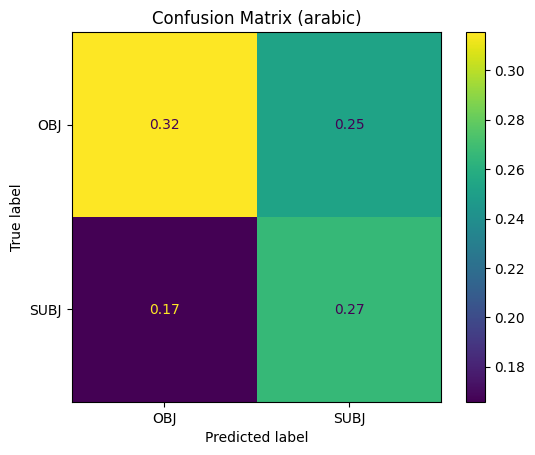

In [30]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTta v3 base (Bulgarian)

In [31]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


20942

In [32]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [33]:
language = 'bulgarian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/729 [00:00<?, ? examples/s]

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [34]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [35]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [36]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

Saved predictions into file: results/dev_bulgarian_predicted.tsv


Saved predictions into file: results/test_bulgarian_predicted.tsv
{'macro_F1': 0.7681505034446212, 'macro_P': 0.7736001617141701, 'macro_R': 0.765374812103784, 'SUBJ_F1': 0.7254901960784315, 'SUBJ_P': 0.7628865979381443, 'SUBJ_R': 0.6915887850467289, 'accuracy': 0.776}


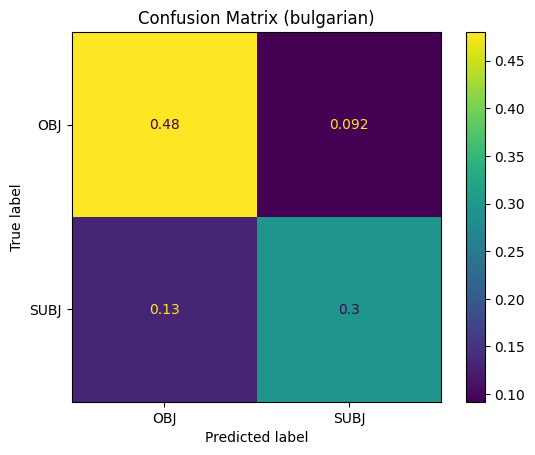

In [37]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (English)

In [38]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5413

In [39]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [40]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [41]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [42]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [43]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

Saved predictions into file: results/dev_english_predicted.tsv


Saved predictions into file: results/test_english_predicted.tsv
{'macro_F1': 0.6649712583140217, 'macro_P': 0.6785538867202647, 'macro_R': 0.6563943483380129, 'SUBJ_F1': 0.484304932735426, 'SUBJ_P': 0.5346534653465347, 'SUBJ_R': 0.4426229508196721, 'accuracy': 0.762396694214876}


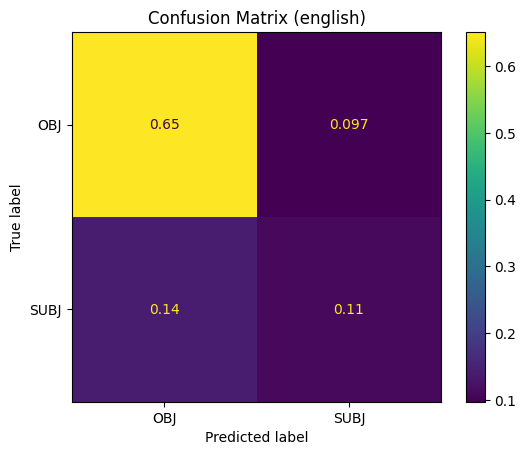

In [44]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTta v3 base (German)

In [45]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5249

In [46]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [47]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [48]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [49]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [50]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

Saved predictions into file: results/dev_german_predicted.tsv


Saved predictions into file: results/test_german_predicted.tsv
{'macro_F1': 0.8217978848413632, 'macro_P': 0.8169956055816823, 'macro_R': 0.8278123255999362, 'SUBJ_F1': 0.7652173913043478, 'SUBJ_P': 0.7394957983193278, 'SUBJ_R': 0.7927927927927928, 'accuracy': 0.8397626112759644}


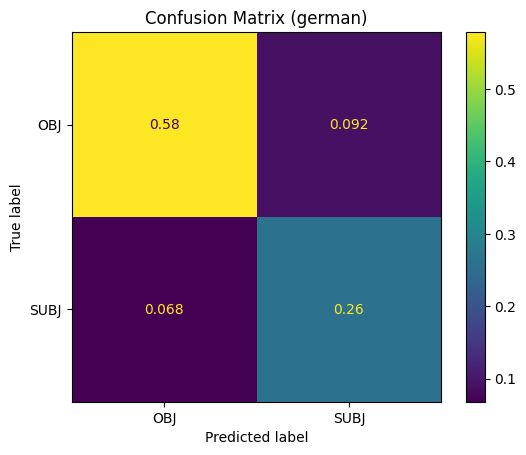

In [51]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (italian)

In [52]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5157

In [53]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [54]:
language = 'italian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/1613 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

In [55]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [56]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [57]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

Saved predictions into file: results/dev_italian_predicted.tsv


Saved predictions into file: results/test_italian_predicted.tsv
{'macro_F1': 0.765381224274257, 'macro_P': 0.7579397021696974, 'macro_R': 0.7749941488531752, 'SUBJ_F1': 0.6620209059233448, 'SUBJ_P': 0.6291390728476821, 'SUBJ_R': 0.6985294117647058, 'accuracy': 0.8109161793372319}


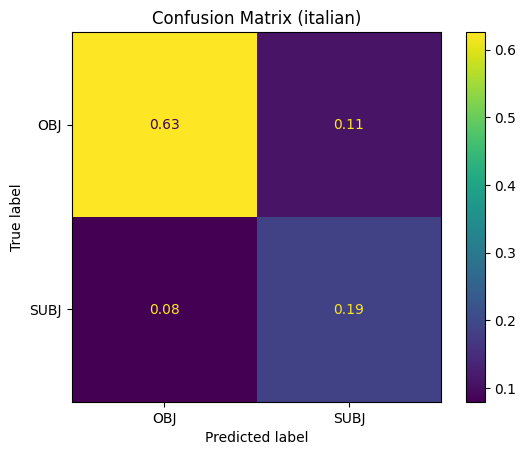

In [58]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (multilingual)

In [59]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5249

In [60]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [61]:
language = 'multilingual'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.train)
dev_data = Dataset.from_pandas(detector.dev)
test_data = Dataset.from_pandas(detector.test)

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.train)

Map:   0%|          | 0/6418 [00:00<?, ? examples/s]

Map:   0%|          | 0/2401 [00:00<?, ? examples/s]

Map:   0%|          | 0/2332 [00:00<?, ? examples/s]

In [62]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [63]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [64]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_multilingual_predicted.tsv


Saved predictions into file: results/test_multilingual_predicted.tsv
{'macro_F1': 0.6941601722041967, 'macro_P': 0.6906958894763773, 'macro_R': 0.7008144557735656, 'SUBJ_F1': 0.6114050558495003, 'SUBJ_P': 0.5764966740576497, 'SUBJ_R': 0.6508135168961201, 'accuracy': 0.7165523156089194}


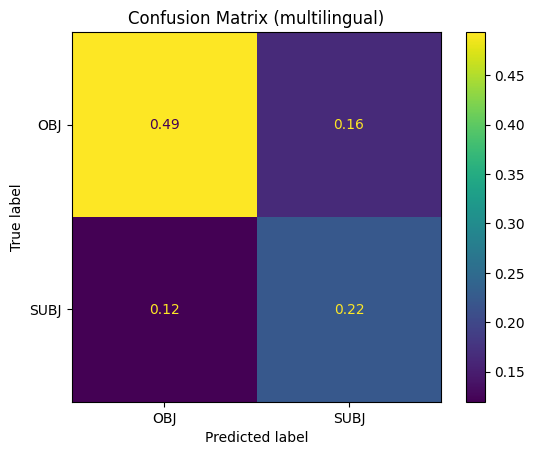

In [65]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

# ModernBERT-base (English)

In [66]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5311

In [67]:
model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [68]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [69]:
model = detector.get_model(
    model_card=f"MatteoFasulo/ModernBERT-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

In [70]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [71]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_english_modern_predicted.tsv


Saved predictions into file: results/test_english_modern_predicted.tsv
{'macro_F1': 0.692169742466896, 'macro_P': 0.6829268292682926, 'macro_R': 0.7119373245177067, 'SUBJ_F1': 0.5611510791366907, 'SUBJ_P': 0.5, 'SUBJ_R': 0.639344262295082, 'accuracy': 0.7479338842975206}


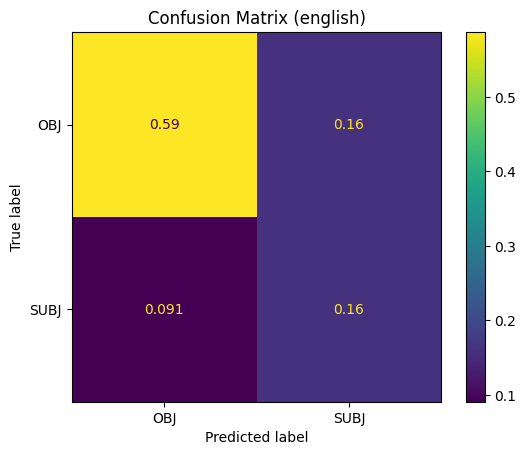

In [72]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_modern_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_modern_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

# Llama-3.2-1B (English)

In [73]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5133

In [74]:
model_card = "meta-llama/Llama-3.2-1B" # meta-llama/Meta-Llama-3-8B
language = 'english'

In [75]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = False, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [76]:
tokenizer = AutoTokenizer.from_pretrained(model_card, add_prefix_space=True)
model = AutoModelForSequenceClassification.from_pretrained(
    f"MatteoFasulo/Llama-3.2-1B-subjectivity-{language}",
    #quantization_config=quantization_config,
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

In [ ]:
model = prepare_model_for_kbit_training(model)
model

In [ ]:
model = get_peft_model(model, lora_config)
model

In [77]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [78]:
epochs = 6
batch_size = 16
lr = 1e-4
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [79]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"Llama-3.2-1B-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [80]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_english_llama_predicted.tsv


Saved predictions into file: results/test_english_llama_predicted.tsv
{'macro_F1': 0.6375322645144872, 'macro_P': 0.7426753611375265, 'macro_R': 0.6213431754370076, 'SUBJ_F1': 0.4046242774566474, 'SUBJ_P': 0.6862745098039216, 'SUBJ_R': 0.28688524590163933, 'accuracy': 0.7871900826446281}


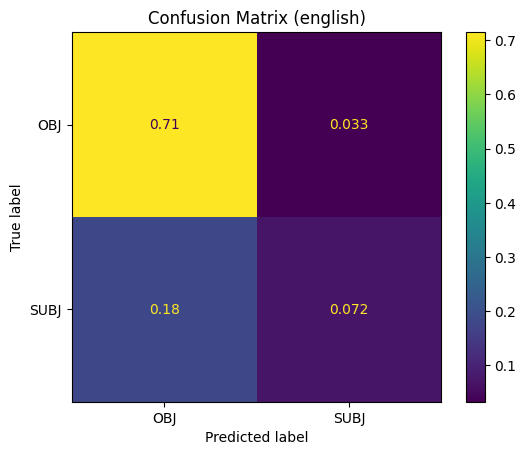

In [81]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_llama_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_llama_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"llama3.2-1B-{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

In [ ]:
# Test - Translating Arab to English

with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = AutoModelForSequenceClassification.from_pretrained(
    model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

language = 'arabic'

!ct2-transformers-converter --model Helsinki-NLP/opus-mt-ar-en --output_dir opus-mt-ar-en

import ctranslate2
import transformers

translator = ctranslate2.Translator("opus-mt-ar-en", device='cuda')
tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ar-en")

def translate_text(raw_text):
    source = tokenizer.convert_ids_to_tokens(tokenizer.encode(raw_text))
    results = translator.translate_batch([source])
    target = results[0].hypotheses[0]
    translation = tokenizer.decode(tokenizer.convert_tokens_to_ids(target))
    return translation

detector.all_data[language]['train']['translated_sentence'] = detector.all_data[language]['train']['sentence'].progress_apply(translate_text)

detector.all_data[language]['dev']['translated_sentence'] = detector.all_data[language]['dev']['sentence'].progress_apply(translate_text)

detector.all_data[language]['test']['translated_sentence'] = detector.all_data[language]['test']['sentence'].progress_apply(translate_text)

detector.all_data[language]['train'].to_csv('/kaggle/working/train_ar.csv')
detector.all_data[language]['dev'].to_csv('/kaggle/working/dev_ar.csv')
detector.all_data[language]['test'].to_csv('/kaggle/working/dev_test_ar.csv')

detector.all_data[language]['train'] = pd.read_csv('/kaggle/working/train_ar.csv')
detector.all_data[language]['dev'] = pd.read_csv('/kaggle/working/dev_ar.csv')
detector.all_data[language]['test'] = pd.read_csv('/kaggle/working/dev_test_ar.csv')

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

def tokenize_text(texts):
    return tokenizer(texts['translated_sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights
)

trainer.train()

best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"llama3.2-1B-{language}"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

# mdeberta-v3-base (arabic + sentiment)

In [46]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5172

In [47]:
class CustomModel(PreTrainedModel):
    config_class = DebertaV2Config

    def __init__(self, config, sentiment_dim=3, num_labels=2, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(output_dim + sentiment_dim, num_labels)

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine CLS embedding with sentiment features
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Classification head
        logits = self.classifier(self.dropout(combined_features))
        
        return {'logits': logits}

In [48]:
language = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [49]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

In [50]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/2446 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

In [51]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [52]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_arabic_sentiment_predicted.tsv


Saved predictions into file: results/test_arabic_sentiment_predicted.tsv
{'macro_F1': 0.573528649533604, 'macro_P': 0.5846455544863383, 'macro_R': 0.5845820433436533, 'SUBJ_F1': 0.5740987983978638, 'SUBJ_P': 0.5046948356807511, 'SUBJ_R': 0.6656346749226006, 'accuracy': 0.5735294117647058}


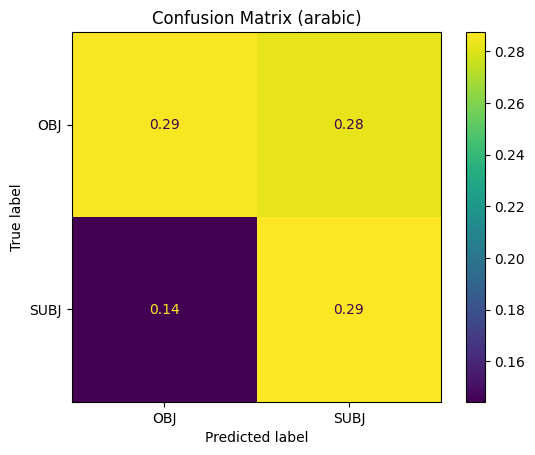

In [53]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mdeberta-v3-base (bulgarian + sentiment)

In [54]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5355

In [55]:
class CustomModel(PreTrainedModel):
    config_class = DebertaV2Config

    def __init__(self, config, sentiment_dim=3, num_labels=2, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(output_dim + sentiment_dim, num_labels)

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine CLS embedding with sentiment features
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Classification head
        logits = self.classifier(self.dropout(combined_features))
        
        return {'logits': logits}

In [56]:
language = 'bulgarian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [57]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [58]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 250/250 [00:02<00:00, 124.79it/s]


In [59]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/729 [00:00<?, ? examples/s]

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [60]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [61]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_bulgarian_sentiment_predicted.tsv


Saved predictions into file: results/test_bulgarian_sentiment_predicted.tsv
{'macro_F1': 0.7717788210745957, 'macro_P': 0.7712277962131564, 'macro_R': 0.7724331743023332, 'SUBJ_F1': 0.7407407407407407, 'SUBJ_P': 0.7339449541284404, 'SUBJ_R': 0.7476635514018691, 'accuracy': 0.776}


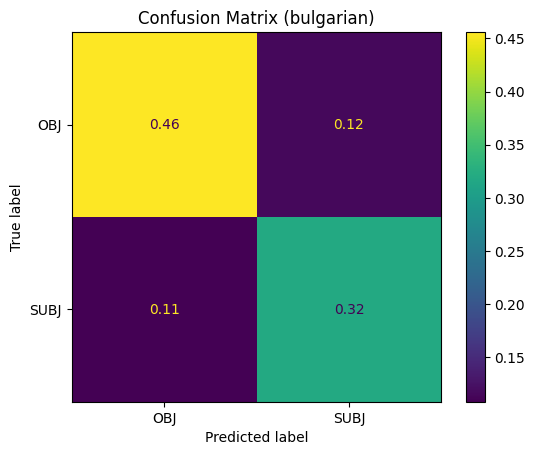

In [62]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mdeberta-v3-base (english + sentiment)

In [63]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5349

In [64]:
class CustomModel(PreTrainedModel):
    config_class = DebertaV2Config

    def __init__(self, config, sentiment_dim=3, num_labels=2, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(output_dim + sentiment_dim, num_labels)

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine CLS embedding with sentiment features
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Classification head
        logits = self.classifier(self.dropout(combined_features))
        
        return {'logits': logits}

In [65]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [66]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [67]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 484/484 [00:03<00:00, 124.31it/s]


In [68]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [69]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [70]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_english_sentiment_predicted.tsv


Saved predictions into file: results/test_english_sentiment_predicted.tsv
{'macro_F1': 0.7036481068162515, 'macro_P': 0.7610920945395273, 'macro_R': 0.6813467982972556, 'SUBJ_F1': 0.5279187817258882, 'SUBJ_P': 0.6933333333333334, 'SUBJ_R': 0.4262295081967213, 'accuracy': 0.8078512396694215}


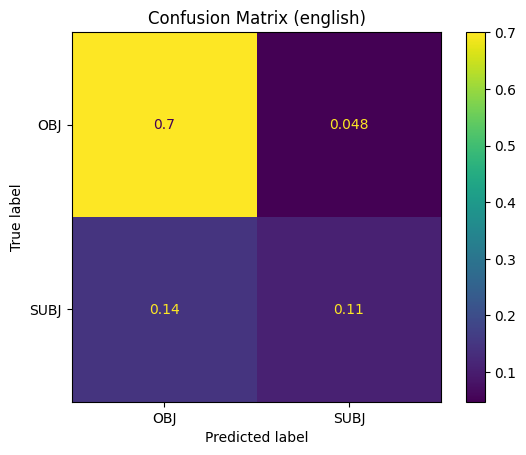

In [71]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mdeberta-v3-base (italian + sentiment)

In [72]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5297

In [73]:
class CustomModel(PreTrainedModel):
    config_class = DebertaV2Config

    def __init__(self, config, sentiment_dim=3, num_labels=2, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(output_dim + sentiment_dim, num_labels)

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine CLS embedding with sentiment features
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Classification head
        logits = self.classifier(self.dropout(combined_features))
        
        return {'logits': logits}

In [74]:
language = 'italian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [75]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [76]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 513/513 [00:04<00:00, 123.48it/s]


In [77]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/1613 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

In [78]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [79]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_italian_sentiment_predicted.tsv


Saved predictions into file: results/test_italian_sentiment_predicted.tsv
{'macro_F1': 0.7769408794445614, 'macro_P': 0.7676788610560461, 'macro_R': 0.7897000312061164, 'SUBJ_F1': 0.6804123711340205, 'SUBJ_P': 0.6387096774193548, 'SUBJ_R': 0.7279411764705882, 'accuracy': 0.8187134502923976}


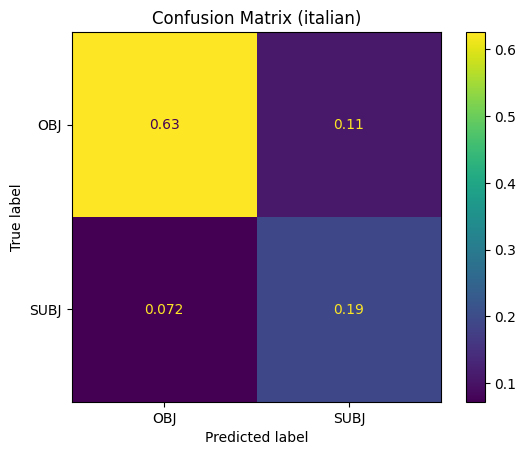

In [80]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mdeberta-v3-base (german + sentiment)

In [81]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5288

In [82]:
class CustomModel(PreTrainedModel):
    config_class = DebertaV2Config

    def __init__(self, config, sentiment_dim=3, num_labels=2, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(output_dim + sentiment_dim, num_labels)

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine CLS embedding with sentiment features
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Classification head
        logits = self.classifier(self.dropout(combined_features))
        
        return {'logits': logits}

In [83]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [84]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [85]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 337/337 [00:02<00:00, 124.02it/s]


In [86]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [87]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [88]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_german_sentiment_predicted.tsv


Saved predictions into file: results/test_german_sentiment_predicted.tsv
{'macro_F1': 0.829107505070994, 'macro_P': 0.8232897153351699, 'macro_R': 0.8368213346089453, 'SUBJ_F1': 0.7758620689655173, 'SUBJ_P': 0.743801652892562, 'SUBJ_R': 0.8108108108108109, 'accuracy': 0.8456973293768546}


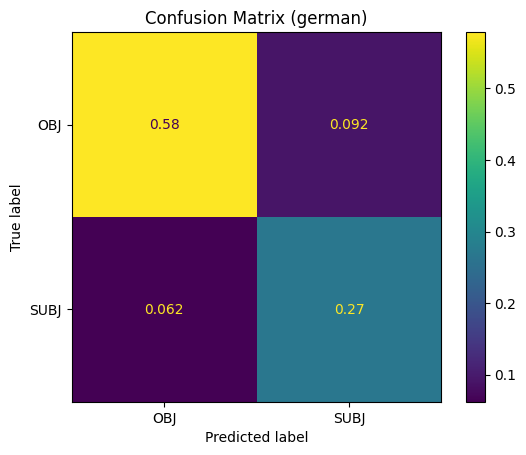

In [89]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (multilingual + sentiment)

In [90]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5161

In [91]:
class CustomModel(PreTrainedModel):
    config_class = DebertaV2Config

    def __init__(self, config, sentiment_dim=3, num_labels=2, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(output_dim + sentiment_dim, num_labels)

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine CLS embedding with sentiment features
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Classification head
        logits = self.classifier(self.dropout(combined_features))
        
        return {'logits': logits}

In [92]:
language = 'multilingual'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [93]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [94]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.train[['positive', 'neutral', 'negative']] = detector.train.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.dev[['positive', 'neutral', 'negative']] = detector.dev.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.test[['positive', 'neutral', 'negative']] = detector.test.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 2332/2332 [00:19<00:00, 121.09it/s]


In [95]:
train_data = Dataset.from_pandas(detector.train)
dev_data = Dataset.from_pandas(detector.dev)
test_data = Dataset.from_pandas(detector.test)

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.train)

Map:   0%|          | 0/6418 [00:00<?, ? examples/s]

Map:   0%|          | 0/2401 [00:00<?, ? examples/s]

Map:   0%|          | 0/2332 [00:00<?, ? examples/s]

In [96]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [97]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_multilingual_sentiment_predicted.tsv


Saved predictions into file: results/test_multilingual_sentiment_predicted.tsv
{'macro_F1': 0.6798492181682799, 'macro_P': 0.73863768566673, 'macro_R': 0.6691404046316866, 'SUBJ_F1': 0.5332278481012658, 'SUBJ_P': 0.7247311827956989, 'SUBJ_R': 0.42177722152690866, 'accuracy': 0.7469982847341338}


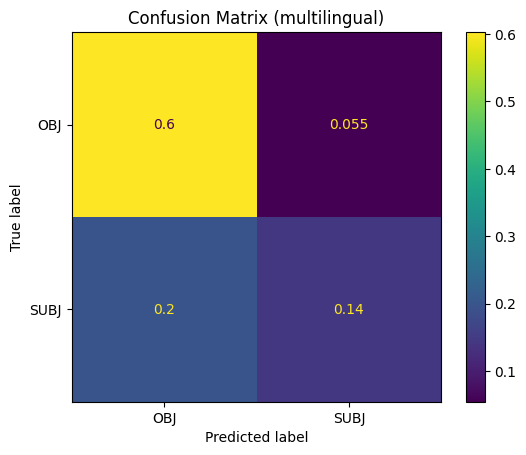

In [98]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

In [99]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False).round(4)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
german-sentiment-thr,0.8291,0.8233,0.8368,0.7759,0.7438,0.8108,0.8457
italian-sentiment-thr,0.7769,0.7677,0.7897,0.6804,0.6387,0.7279,0.8187
bulgarian-sentiment-thr,0.7718,0.7712,0.7724,0.7407,0.7339,0.7477,0.7760
english-sentiment-thr,0.7036,0.7611,0.6813,0.5279,0.6933,0.4262,0.8079
multilingual-sentiment-thr,0.6798,0.7386,0.6691,0.5332,0.7247,0.4218,0.7470
arabic-sentiment-thr,0.5735,0.5846,0.5846,0.5741,0.5047,0.6656,0.5735


In [76]:
predictions_dict['true_labels'] = labels
predictions_dict['sentence'] = test_data['sentence']
predictions_dict['sentence_id'] = test_data['sentence_id']
predictions_dict['positive'] = test_data['positive']
predictions_dict['neutral'] = test_data['neutral']
predictions_dict['negative'] = test_data['negative']

In [77]:
predictions_df = pd.DataFrame(predictions_dict)
predictions_df.head()

,english-sentiment-thr,english-thr,english-modern-bert-thr,true_labels,sentence,sentence_id,positive,neutral,negative
0,0,0,0,0,Blanco established himself earlier in his care...,44f33601-157a-42ce-aa9f-0f7d305501f2,0.802878,0.178354,0.018768
1,0,0,0,0,RULE 13: ARTIFICIAL INTELLIGENCE Not only thi...,6f9e0f53-f76c-432f-bbea-b78400d600b8,0.508778,0.389381,0.101840
2,0,0,0,0,The valuation is required by law and the figur...,61f93bdc-4c3e-4963-926c-0bbf139b44b9,0.849510,0.093090,0.057400
3,1,1,0,1,A sip can really hit the spot after a long bik...,902148ec-dda3-4736-b318-0f20c63a1cf3,0.220061,0.736456,0.043484
4,0,0,0,0,"""Lobster!""""""",065b1996-4b40-4c74-9f62-afb44f69834e,0.444932,0.295773,0.259295


In [78]:
predictions_df.to_csv('predictions_to_be_compared.csv', index=False, encoding='UTF-8')

In [79]:
# correct guess but sentiment provides better understanding
predictions_df[(predictions_df['english-sentiment-thr'] == predictions_df['true_labels']) & 
                (predictions_df['english-sentiment-thr'] != predictions_df['english-thr'])]

,english-sentiment-thr,english-thr,english-modern-bert-thr,true_labels,sentence,sentence_id,positive,neutral,negative
6,0,1,1,0,Googled how to cook a good lobster and I read ...,d5429c1d-802b-4427-8ffa-88ac62091a62,0.128520,0.024822,0.846658
48,0,1,1,0,This is why the more Osborne slashed public sp...,f77261bb-91b1-4f85-809c-8a588bcf1ab7,0.410512,0.116610,0.472878
49,0,1,1,0,"When your credit card is “maxed out”, you do i...",2510c90d-872b-44f3-9329-7e614f6ba821,0.268093,0.042711,0.689196
50,0,1,1,0,This was inaccurate.,fd834368-aa38-4dd6-aecd-ad2d6ac00ad0,0.078637,0.020564,0.900799
55,0,1,0,0,"""I know you was heartbroken lol.""""""",4e021920-81a3-44e0-97e7-e5fc7d0acb46,0.361328,0.119520,0.519152
58,0,1,0,0,I scribbled down what I saw and what I felt an...,b256f52b-e2ce-49f5-b3be-8b2e48e99000,0.681925,0.182852,0.135223
61,0,1,0,0,"""But one person who knows exactly what's that ...",c8840daf-2871-4d51-9c40-53d22cd8a8f8,0.070693,0.010807,0.918500
68,0,1,0,0,"""""""I'm not really a gambler - it was a $10k (£...",03802121-73ba-427a-8a60-1a5d3bc64dfe,0.565224,0.120331,0.314445
69,0,1,0,0,When it was an Emma and Dex day I felt good ab...,3934802e-66b0-4501-9ff2-2a4ce3b19371,0.230351,0.737375,0.032274
100,0,1,0,0,Bring it out done.',ef352be8-43ca-4627-bc90-9477a3e0e322,0.618892,0.335233,0.045875


---

# Zero shot inference

## Utility function

This function can be then integrated in the Subjectivity class

In [11]:
def zero_shot_prepare_data(train_languages : list,
                           train : pd.DataFrame,
                           dev : pd.DataFrame,
                           test : pd.DataFrame):

    
    train_set = train[train["lang"].isin(train_languages)].copy()
    dev_set = dev[~dev["lang"].isin(train_languages)].copy()
    test_set = test[~test["lang"].isin(train_languages)].copy()

    return train_set, dev_set, test_set

In [12]:
def generate_name(names : tuple):
    generated_name = ""
    for x in names:
        generated_name = generated_name + x.capitalize()[:2]
    return generated_name

## Custom loop to test triplets

In [22]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, weights_dtype=torch.float32, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=weights_dtype).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extract labels
        labels = inputs.get("labels")

        # Forward pass
        outputs = model(**inputs)

        # Extract logits 
        logits = outputs.get('logits')

        # Compute loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_best_threshold(self, dataset, ignore_keys=None, metric_key_prefix="test"):
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)

        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()

        # Calculate optimal threshold
        labels = output.label_ids
        thresholds = np.linspace(0.1, 0.9, 100) 

        best_threshold = 0.5  # Default threshold
        best_f1 = 0

        for threshold in thresholds:
            predictions = (probabilities[:, 1] >= threshold).astype(int)
            _, _, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        # Return the best threshold found
        return best_threshold
        

    def predict(self, dataset, threshold: float = 0.5, ignore_keys=None, metric_key_prefix="test"):
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)
        
        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()
        
        final_predictions = (probabilities[:, 1] >= threshold).astype(int)

        # Update predictions in the output object
        return PredictionOutput(
            predictions=final_predictions,
            label_ids=output.label_ids,
            metrics=output.metrics
        )

In [23]:
def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}


In [26]:
import itertools
results = {}
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

training_args = TrainingArguments(
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)


for i, group in enumerate([('english','italian')]):
    print(f"TESTING {i} - {group}")
    with torch.no_grad():
        torch.cuda.empty_cache()
    if 'model' in locals() or 'model' in globals():
        del model
        print("Model deleted!")
    gc.collect()
    
    group_name = generate_name(group)

    zs_train, zs_dev, zs_test = zero_shot_prepare_data(group, detector.train, detector.dev, detector.test)

    language = group_name+'-NoSentiment'


    
    train_data = Dataset.from_pandas(zs_train)
    dev_data = Dataset.from_pandas(zs_dev)
    test_data = Dataset.from_pandas(zs_test)
    
    train_data = train_data.map(tokenize_text, batched=True)
    dev_data = dev_data.map(tokenize_text, batched=True)
    test_data = test_data.map(tokenize_text, batched=True)
    
    class_weights = detector.get_class_weights(zs_train)

    model = detector.get_model(
        model_card=model_card, 
        num_labels=2, 
        id2label={0: 'OBJ', 1: 'SUBJ'}, 
        label2id={'OBJ': 0, 'SUBJ': 1},
        output_attentions = False,
        output_hidden_states = False
    )
    
    collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        data_collator=collator_fn,
        compute_metrics=evaluate_metrics,
        class_weights=class_weights,
    )

    trainer.train()

    best_thr = trainer.compute_best_threshold(dataset=dev_data)
    pred_info = trainer.predict(dataset=test_data, threshold=best_thr)
    predictions, labels = pred_info.predictions, pred_info.label_ids
    
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)
    stats = {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }
    
    results[language] = stats

    
    with torch.no_grad():
        torch.cuda.empty_cache()
    if 'model' in locals() or 'model' in globals():
        del model
        print("Model deleted!")
    gc.collect()

    language = group_name+'-Sentiment'
    
    model = CustomModel(
        model_name=model_card, 
        num_labels=2, 
        sentiment_dim=3
    )



    zs_train[['positive', 'neutral', 'negative']] = zs_train.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
    zs_dev[['positive', 'neutral', 'negative']] = zs_dev.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
    zs_test[['positive', 'neutral', 'negative']] = zs_test.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

    train_data = Dataset.from_pandas(zs_train)
    dev_data = Dataset.from_pandas(zs_dev)
    test_data = Dataset.from_pandas(zs_test)

    train_data = train_data.map(tokenize_text, batched=True)
    dev_data = dev_data.map(tokenize_text, batched=True)
    test_data = test_data.map(tokenize_text, batched=True)

    collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = CustomTrainer(
        model = model,
        args = training_args,
        train_dataset = train_data,
        eval_dataset = dev_data,
        data_collator = collator_fn,
        compute_metrics = evaluate_metrics,
        class_weights=class_weights,
    )

    trainer.train()

    best_thr = trainer.compute_best_threshold(dataset=dev_data)
    pred_info = trainer.predict(dataset=test_data, threshold=best_thr)
    predictions, labels = pred_info.predictions, pred_info.label_ids
    
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)
    stats = {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }
    
    results[language] = stats
    
    

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


TESTING 0 - ('english', 'italian')
Model deleted!


Map:   0%|          | 0/2443 [00:00<?, ? examples/s]

Map:   0%|          | 0/1272 [00:00<?, ? examples/s]

Map:   0%|          | 0/1335 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.657371,0.668724,0.668303,0.669217,0.607522,0.602294,0.612840,0.680031
2,No log,0.828612,0.645487,0.692242,0.645853,0.519512,0.696078,0.414397,0.690252
3,No log,1.014649,0.661566,0.695910,0.659338,0.550351,0.691176,0.457198,0.698113
4,0.446900,1.211402,0.649742,0.693915,0.649397,0.527207,0.696486,0.424125,0.692610
5,0.446900,1.423838,0.649075,0.700674,0.649497,0.522167,0.711409,0.412451,0.694969
6,0.446900,1.465843,0.647287,0.694394,0.647485,0.521951,0.699346,0.416342,0.691824


Model deleted!


100%|██████████| 1335/1335 [00:11<00:00, 119.28it/s]


Map:   0%|          | 0/2443 [00:00<?, ? examples/s]

Map:   0%|          | 0/1272 [00:00<?, ? examples/s]

Map:   0%|          | 0/1335 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.725917,0.612220,0.629209,0.631277,0.603379,0.514403,0.729572,0.612421
2,No log,0.972189,0.634223,0.718251,0.640070,0.486129,0.757202,0.357977,0.694182
3,No log,0.955200,0.685101,0.702052,0.681131,0.596721,0.680798,0.531128,0.709906
4,0.504100,1.252779,0.653370,0.706423,0.653422,0.527744,0.720539,0.416342,0.698899
5,0.504100,1.394758,0.648759,0.707636,0.649911,0.518148,0.726316,0.402724,0.697327
6,0.504100,1.417408,0.653806,0.701681,0.653355,0.531060,0.710098,0.424125,0.697327


In [27]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False).round(4)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
EnIt-NoSentiment,0.6147,0.6219,0.6135,0.5166,0.5661,0.4750,0.6397
EnIt-Sentiment,0.6022,0.6074,0.6012,0.5045,0.5451,0.4695,0.6262


In [ ]:
dataframe = pd.DataFrame(results)

In [ ]:
dataframe.to_csv("results.csv")

---

In [129]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


10705

In [130]:
class CustomModel(PreTrainedModel):
    config_class = DebertaV2Config

    def __init__(self, config, sentiment_dim=3, num_labels=2):
        super().__init__(config)
        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        self.dropout = nn.Dropout(0.1)
        
        # Attention-based sentiment fusion
        self.sentiment_projection = nn.Linear(sentiment_dim, config.hidden_size)
        self.attention = nn.MultiheadAttention(embed_dim=config.hidden_size, num_heads=1, batch_first=True)

        # Classification head
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        
    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        encoder_layer = outputs.last_hidden_state
        pooled_output = self.pooler(encoder_layer)  # Shape: (batch_size, hidden_size)
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        sentiment_features = self.sentiment_projection(sentiment_features).unsqueeze(1)  # Project to hidden size

        # Attention mechanism
        attention_output, _ = self.attention(pooled_output.unsqueeze(1), sentiment_features, sentiment_features)
        enhanced_features = pooled_output + attention_output.squeeze(1)  # Residual connection

        # Apply dropout and classification
        logits = self.classifier(self.dropout(enhanced_features))
        
        return {'logits': logits}

In [131]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [132]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    model_card,
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2)

# Load pretrained weights from the original DeBERTa model
model.deberta = DebertaV2Model.from_pretrained(model_card, config=config)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [133]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 484/484 [00:04<00:00, 120.10it/s]


In [134]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [135]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [136]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.676271,0.638498,0.650187,0.644707,0.610329,0.698925,0.541667,0.640693
2,No log,0.492784,0.766216,0.768179,0.767736,0.764192,0.802752,0.729167,0.766234
3,No log,0.512452,0.767482,0.779157,0.772016,0.752887,0.844560,0.679167,0.768398
4,No log,0.506866,0.792145,0.795240,0.794088,0.788546,0.836449,0.745833,0.792208


In [ ]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()